# Define some paths

In [4]:
base_path = '/home/ec2-user/'
s3_base_path = base_path + 's3/'
s3_data_path = s3_base_path + 'data/'
s3_results_path = s3_base_path + 'results/'

s3_bucket_name = 'borowis-s3-us-east-1'

In [5]:
data_path = base_path + 'data/'
train_path = data_path + 'train/'
test_path = data_path + 'test/'
valid_path = data_path + 'valid/'
sample_path = data_path + 'sample/'

In [6]:
categories = ['c' + str(i) for i in range(10)]

# Imports

In [1]:
from utils import *
import vgg16; reload(vgg16)
from vgg16 import Vgg16

%matplotlib inline

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5103)
/usr/local/lib/python2.7/site-packages/Theano-0.8.2-py2.7.egg/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [3]:
from keras import backend as K

# Common functions

In [7]:
def plots_idx(base_path, idx, titles=None):
    plots([image.load_img(base_path + filenames[i]) for i in idx], titles=titles)

In [8]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

# Command to sync with aws s3 bucket

In [90]:
!aws s3 sync $s3_base_path $s3_bucket_name


usage: aws [options] <command> <subcommand> [parameters]
aws: error: too few arguments


# Unzip data

In [10]:
!mkdir $data_path
!unzip -q $s3_data_path/imgs.zip -d $data_path
!unzip -q $s3_data_path/driver_imgs_list.csv.zip -d $data_path

mkdir: cannot create directory ‘/home/ec2-user/data/’: File exists


# Create sample/validation sets from statefarm data

Dataset size:

In [11]:
!ls -al $data_path/test/ | wc -l
for c in categories:
    !echo "$c: `ls -al $data_path/train/$c | wc -l`"

79729
c0: 2492
c1: 2270
c2: 2320
c3: 2349
c4: 2329
c5: 2315
c6: 2328
c7: 2005
c8: 1914
c9: 2132


We have test / train set, now we need a validaton set and sample set

In [12]:
!mkdir $valid_path
for c in categories:
    !mkdir $valid_path/$c

!ls -al $valid_path

total 48
drwxrwxr-x 12 ec2-user ec2-user 4096 Nov 19 19:40 .
drwxr-xr-x  5 ec2-user ec2-user 4096 Nov 19 19:40 ..
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:40 c0
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:40 c1
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:40 c2
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:40 c3
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:40 c4
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:40 c5
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:40 c6
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:40 c7
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:40 c8
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:40 c9


In [13]:
!mkdir $sample_path
!mkdir $sample_path/train
!mkdir $sample_path/valid

for c in categories:
    !mkdir $sample_path/train/$c
    !mkdir $sample_path/valid/$c

In [14]:
!ls -al $sample_path/train

total 48
drwxrwxr-x 12 ec2-user ec2-user 4096 Nov 19 19:41 .
drwxrwxr-x  4 ec2-user ec2-user 4096 Nov 19 19:41 ..
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c0
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c1
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c2
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c3
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c4
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c5
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c6
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c7
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c8
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c9


In [15]:
!ls -al $sample_path/valid

total 48
drwxrwxr-x 12 ec2-user ec2-user 4096 Nov 19 19:41 .
drwxrwxr-x  4 ec2-user ec2-user 4096 Nov 19 19:41 ..
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c0
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c1
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c2
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c3
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c4
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c5
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c6
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c7
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c8
drwxrwxr-x  2 ec2-user ec2-user 4096 Nov 19 19:41 c9


In [24]:
import pandas as pd

# explore drivers / classes
drivers_df = pd.read_csv(data_path + '/driver_imgs_list.csv')
drivers = drivers_df['subject'].unique()

print (len(drivers))
print (drivers_df.count())
drivers_df.groupby(['subject']).count()

26
subject      22424
classname    22424
img          22424
dtype: int64


,classname,img
subject,,
p002,725,725
p012,823,823
p014,876,876
p015,875,875
p016,1078,1078
p021,1237,1237
p022,1233,1233
p024,1226,1226
p026,1196,1196


In [67]:
import random
import os
import shutil

def sampleOverCategories(base_path, destination_path, categories, sample_size, should_copy=True):
    func = shutil.copy if should_copy else shutil.move
    
    for category in categories:
        category_imgs = os.listdir(base_path + category)
        for category_img in random.sample(category_imgs, sample_size):
            func(base_path + category + '/' + category_img, destination_path + category)
            
def sampleOverDrivers(base_path, destination_path, categories, drivers_df, sample_size, should_copy=False):
    func = shutil.copy if should_copy else shutil.move
    
    for category in categories:
        unique_drivers = {}
        category_imgs = os.listdir(base_path + category)

        # build (driver -> category) map
        for category_img in category_imgs:
            driver = drivers_df[drivers_df['img'] == category_img].iloc[0,0]
            if not driver in unique_drivers:
                unique_drivers[driver] = []

            unique_drivers[driver].append(category_img)

        # select at least sample_size imgs so that 
        # (driver, category) pair is unique in the two sets
        processed = 0
        while processed < sample_size:
            random_driver = random.choice(unique_drivers.keys())
            random_driver_images = unique_drivers.pop(random_driver)

            for random_img in random_driver_images:
                func(base_path + category + '/' + random_img, destination_path + category)

            processed += len(random_driver_images)

In [30]:
#prepare sample set
CAT_SAMPLE_TRAIN_SIZE = 100
CAT_SAMPLE_VALID_SIZE = 10

sampleOverCategories(train_path, sample_path + 'train/', categories, CAT_SAMPLE_TRAIN_SIZE)
sampleOverDrivers(sample_path + 'train/', sample_path + 'valid/', categories, drivers_df, CAT_SAMPLE_VALID_SIZE)

In [74]:
#prepare validation set
CAT_VALID_SIZE = 450

sample(train_path, valid_path, categories, CAT_VALID_SIZE)

Prepare test set

In [75]:
!mkdir $test_path/unknown
!find $test_path -type f -iname '*.jpg' | xargs mv -t $test_path/unknown/

mv: ‘/home/ec2-user/data/test/unknown/img_33694.jpg’ and ‘/home/ec2-user/data/test//unknown/img_33694.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_11806.jpg’ and ‘/home/ec2-user/data/test//unknown/img_11806.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_69387.jpg’ and ‘/home/ec2-user/data/test//unknown/img_69387.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_30820.jpg’ and ‘/home/ec2-user/data/test//unknown/img_30820.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_3613.jpg’ and ‘/home/ec2-user/data/test//unknown/img_3613.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_20854.jpg’ and ‘/home/ec2-user/data/test//unknown/img_20854.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_96679.jpg’ and ‘/home/ec2-user/data/test//unknown/img_96679.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_62028.jpg’ and ‘/home/ec2-user/data/test//unknown/img_62028.jpg’ are the same file
mv

mv: ‘/home/ec2-user/data/test/unknown/img_82349.jpg’ and ‘/home/ec2-user/data/test//unknown/img_82349.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_56086.jpg’ and ‘/home/ec2-user/data/test//unknown/img_56086.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_96676.jpg’ and ‘/home/ec2-user/data/test//unknown/img_96676.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_23096.jpg’ and ‘/home/ec2-user/data/test//unknown/img_23096.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_52336.jpg’ and ‘/home/ec2-user/data/test//unknown/img_52336.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_44159.jpg’ and ‘/home/ec2-user/data/test//unknown/img_44159.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_86072.jpg’ and ‘/home/ec2-user/data/test//unknown/img_86072.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_5762.jpg’ and ‘/home/ec2-user/data/test//unknown/img_5762.jpg’ are the same file
mv

In [76]:
!ls -al $test_path/unknown | wc -l

79729


In [77]:
!echo $data_path

/home/ec2-user/data/


In [78]:
!tar -cf $base_path/statefarm.tar -C $data_path sample/ test/ train/ valid/

# If you already have data

In [7]:
!mkdir $data_path
!tar -xf $s3_data_path/statefarm.tar -C $data_path

# Check directory structure

In [79]:
for c in categories:
    !echo "$c: `ls -al $train_path/$c | wc -l`"

c0: 2492
c1: 2270
c2: 2320
c3: 2349
c4: 2329
c5: 2315
c6: 2328
c7: 2005
c8: 1914
c9: 2132


In [80]:
for c in categories:
    !echo "$c: `ls -al $sample_path/valid/$c | wc -l`"

c0: 14
c1: 15
c2: 13
c3: 15
c4: 15
c5: 14
c6: 14
c7: 13
c8: 13
c9: 13


# Data exploration

In [81]:
n_view = 3
batch_size = 64
sample_val_batches = get_batches(sample_path + 'valid', shuffle=False, batch_size=1)
sample_batches = get_batches(sample_path + 'train', shuffle=False, batch_size=1)

Found 109 images belonging to 10 classes.
Found 891 images belonging to 10 classes.


In [82]:
sample_val_classes = sample_val_batches.classes
sample_trn_classes = sample_batches.classes

sample_val_labels = onehot(sample_val_classes)
sample_trn_labels = onehot(sample_trn_classes)

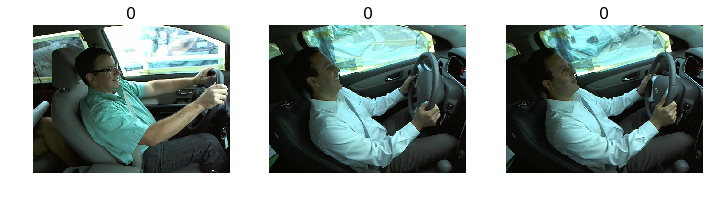

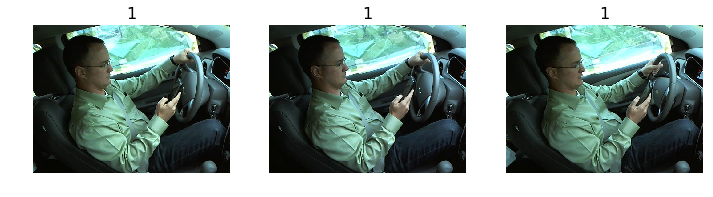

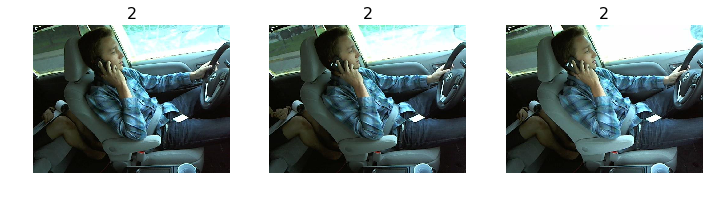

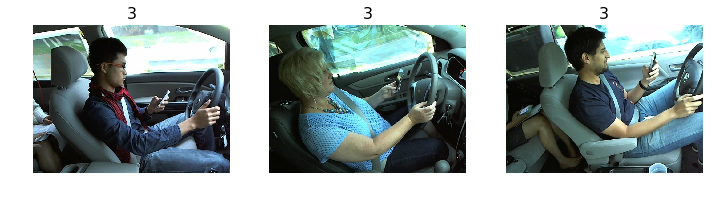

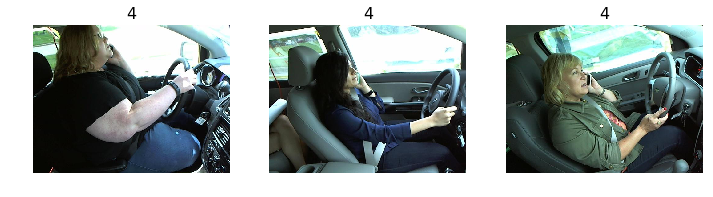

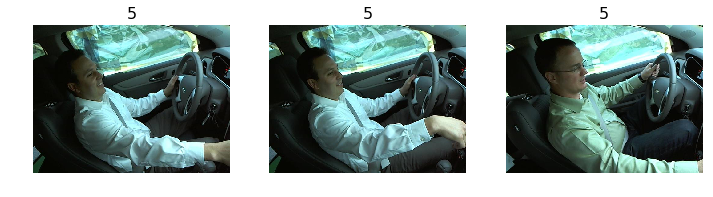

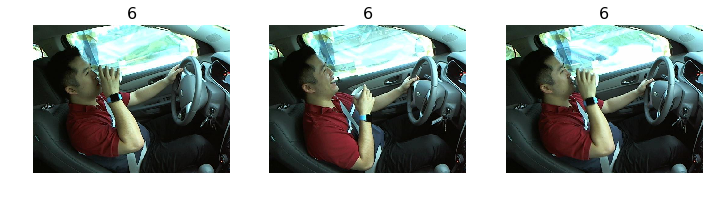

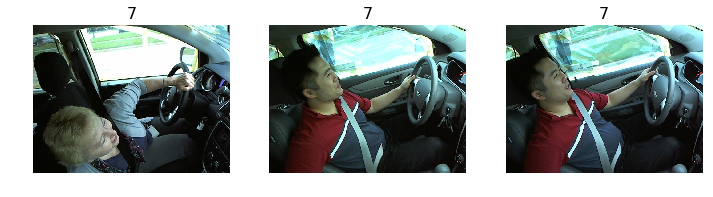

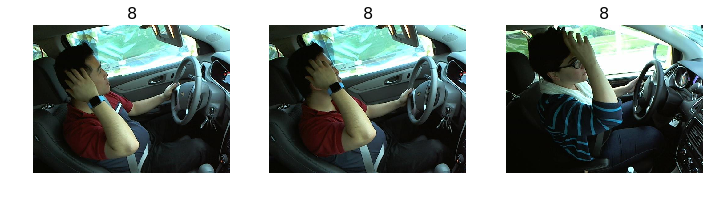

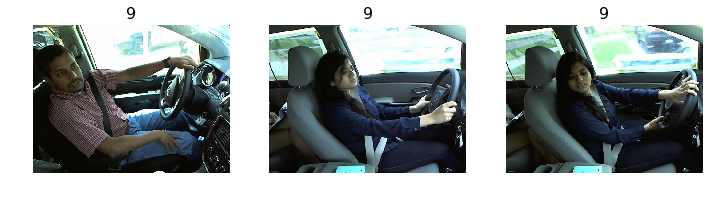

In [83]:
filenames = sample_val_batches.filenames
for i in range(len(categories)):
    plots_idx(sample_path + 'valid/', permutation(np.where(sample_val_classes == i)[0])[:n_view], [i] * n_view)

# Training on sample

In [84]:
sample_vgg = Vgg16()
sample_model = sample_vgg.model

In [85]:
sample_batch_size = 4
sample_val_batches = get_batches(sample_path + 'valid', shuffle=False, batch_size=sample_batch_size)
sample_batches = get_batches(sample_path + 'train', shuffle=True, batch_size=sample_batch_size)

Found 109 images belonging to 10 classes.
Found 891 images belonging to 10 classes.


In [86]:
sample_model.pop()
for layer in sample_model.layers: layer.trainable=False
sample_model.add(Dense(10, activation='softmax'))

# sample_model.summary()

In [87]:
sample_opt = RMSprop(lr=0.001)
sample_model.compile(optimizer=sample_opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
sample_vgg.fit(sample_batches, sample_val_batches, nb_epoch = 1)

In [32]:
sample_vgg.fit(sample_batches, sample_val_batches, nb_epoch = 3)

### Train more layers

In [36]:
sample_layers = sample_model.layers
first_dense_idx = [idx for idx, sample_layer in enumerate(sample_layers) if type(sample_layer) is Dense][0]

for sample_layer in sample_layers[first_dense_idx:]: sample_layer.trainable = True 

In [37]:
K.set_value(sample_opt.lr, 0.0001)

In [38]:
%%time
sample_vgg.fit(sample_batches, sample_val_batches, nb_epoch = 1)


CPU times: user 41.4 s, sys: 4.67 s, total: 46.1 s
Wall time: 29.3 s


### Train even more layers

In [46]:
for sample_layer in sample_layers[:12]: sample_layer.trainable = True

In [57]:
%%time
sample_vgg.fit(sample_batches, sample_val_batches, nb_epoch = 3)


CPU times: user 2min 3s, sys: 13.6 s, total: 2min 17s
Wall time: 1min 27s


### Now, try predictions

In [55]:
_, sample_preds = sample_vgg.test(sample_path + 'valid/', sample_batch_size)

Found 250 images belonging to 10 classes.


In [58]:
print ("Sample predictions\n%s" % np.clip(sample_preds[:10], 0.05, 0.95))

Sample predictions
[[ 0.95    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  ]
 [ 0.95    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  ]
 [ 0.2937  0.05    0.05    0.392   0.0851  0.05    0.05    0.05    0.05    0.1911]
 [ 0.3706  0.4765  0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.0853]
 [ 0.95    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  ]
 [ 0.95    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  ]
 [ 0.8197  0.05    0.05    0.05    0.05    0.05    0.0852  0.05    0.05    0.0597]
 [ 0.9198  0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  ]
 [ 0.95    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  ]
 [ 0.95    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  ]]


In [61]:
print (sample_val_batches.filenames[100:110])
print (sample_batch_size)
#for i in range(10):
#    plots_idx(sample_path + 'valid/', permutation(np.where(sample_val_classes == i)[0])[:n_view], [i] * n_view)

['c4/img_75683.jpg', 'c4/img_64670.jpg', 'c4/img_58147.jpg', 'c4/img_35688.jpg', 'c4/img_50781.jpg', 'c4/img_92005.jpg', 'c4/img_12204.jpg', 'c4/img_77239.jpg', 'c4/img_88178.jpg', 'c4/img_58436.jpg']
4


# Training on full dataset

In [49]:
vgg = Vgg16()
model = vgg.model

In [41]:
batch_size = 64
val_batches = get_batches(valid_path, shuffle=False, batch_size=batch_size)
batches = get_batches(train_path, shuffle=False, batch_size=batch_size)

Found 4500 images belonging to 10 classes.
Found 17924 images belonging to 10 classes.


In [53]:
model.pop()
for layer in model.layers: layer.trainable=False
model.add(Dense(10, activation='softmax'))

opt = RMSprop(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
%%time
vgg.fit(batches, val_batches, nb_epoch = 1)

Epoch 1/1
505s - loss: 14.3031 - acc: 0.1103 - val_loss: 14.5063 - val_acc: 0.1000
CPU times: user 12min 5s, sys: 1min 31s, total: 13min 36s
Wall time: 8min 33s


In [50]:
layers = model.layers
first_dense_idx = [idx for idx, layer in enumerate(layers) if type(layer) is Dense][0]

for layer in layers[first_dense_idx:]: layer.trainable = True 
    
K.set_value(opt.lr, 0.01)

In [51]:
%%time
vgg.fit(batches, val_batches, nb_epoch = 1)

RuntimeError: The model needs to be compiled before being used.